In [1]:
#Config LSTM
config = {
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 32,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}


In [2]:
#Query and Fetch Data
import requests

Company="GOOG"

def QueryData(Company):
    url=  'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={0}&outputsize=full&apikey=8FE7NW93X6D8T1AX'.format(Company)
    r = requests.get(url)
    data = r.json()
    return data

Data = QueryData(Company)

In [3]:
import numpy as np
def ProcessData(data, Frequency):
    Dates=[]
    Prices=[]
    
    for x in data[Frequency]:
        Dates.append(x)
        Prices.append(data[Frequency][x]["5. adjusted close"])
       
    Dates.reverse()
    Dates = np.array(Dates)

    Prices.reverse()
    Prices = np.array(Prices).astype(np.float32)

    NumberDatapoints = len(Dates)
    Date_Range = "from " + Dates[0] + " to " + Dates[NumberDatapoints-1]

    print(Dates[0])
    print(Dates[1])
    return Prices, Dates, NumberDatapoints, Date_Range

Prices, Dates, NumberDatapoints, Date_Range= ProcessData(Data, "Time Series (Daily)")

2014-03-27
2014-03-28


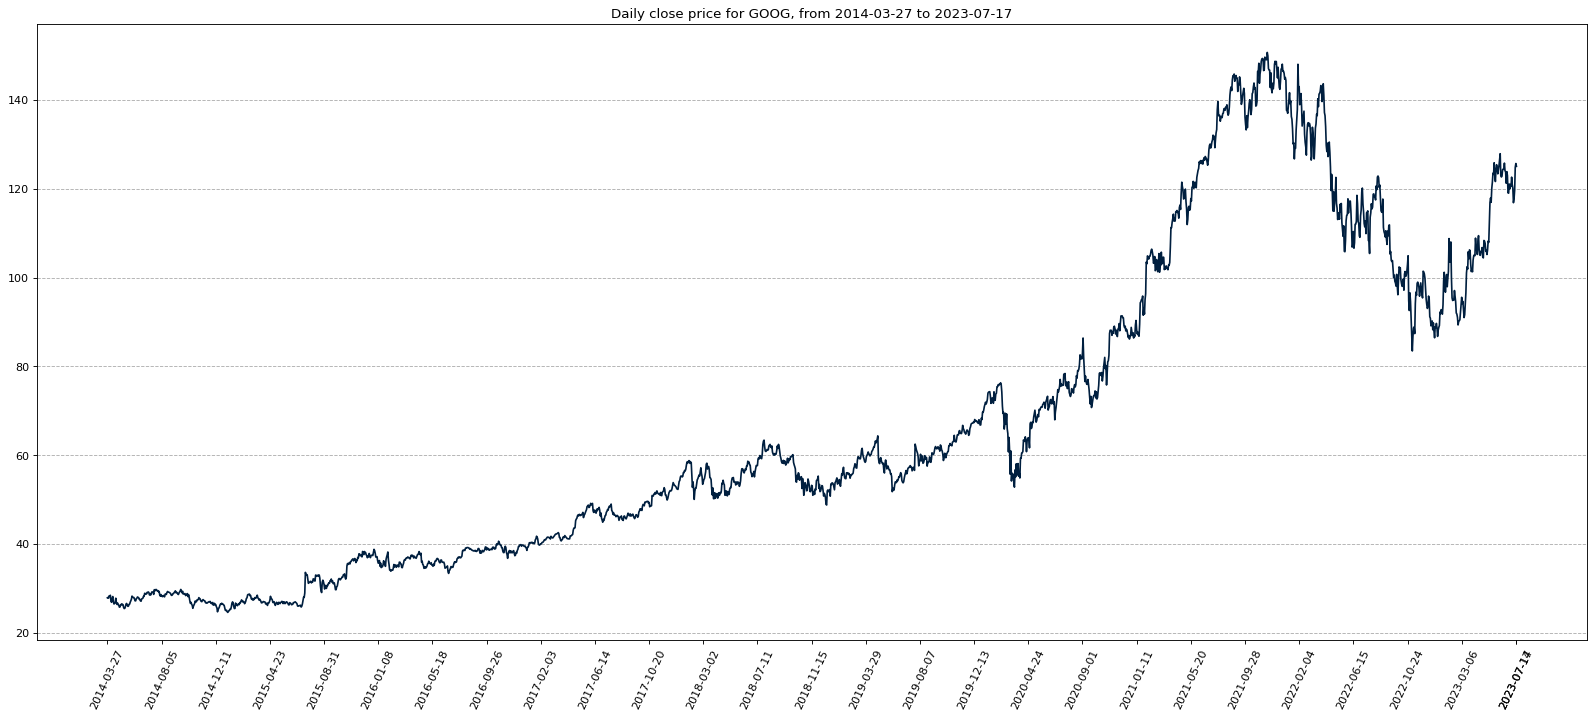

In [4]:
#Plot Data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(25, 10), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(Dates, Prices, color=config["plots"]["color_actual"])


xticks = [Dates[i] if ((i%config["plots"]["xticks_interval"]==0) or i==NumberDatapoints-1) else None for i in range(len(Dates))] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks , rotation=65)

ticks2 = ax.xaxis.get_major_ticks()
counter=0
for i in xticks:
    if i is not None:
        ticks2[counter].set_visible(True)
        counter+=1
    else:
        ticks2[counter].set_visible(False)
        counter+=1

plt.title("Daily close price for " + Company + ", " + Date_Range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')



In [5]:
#Normalize Prices
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        Z_Score = (x - self.mu)/self.sd
        return Z_Score

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
Normalized_Prices = scaler.fit_transform(Prices)


In [6]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size +1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(y, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = y[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(Normalized_Prices, window_size=config["data"]["window_size"])
data_y = prepare_data_y(Normalized_Prices, window_size=config["data"]["window_size"])

print("Shape of x is: ", data_x.shape)

Shape of x is:  (2322, 20)


In [7]:
#Split

split_index = int(config["data"]["train_split_size"]*len(data_x))
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]

data_y_train =data_y[:split_index]
data_y_val = data_y[split_index:]

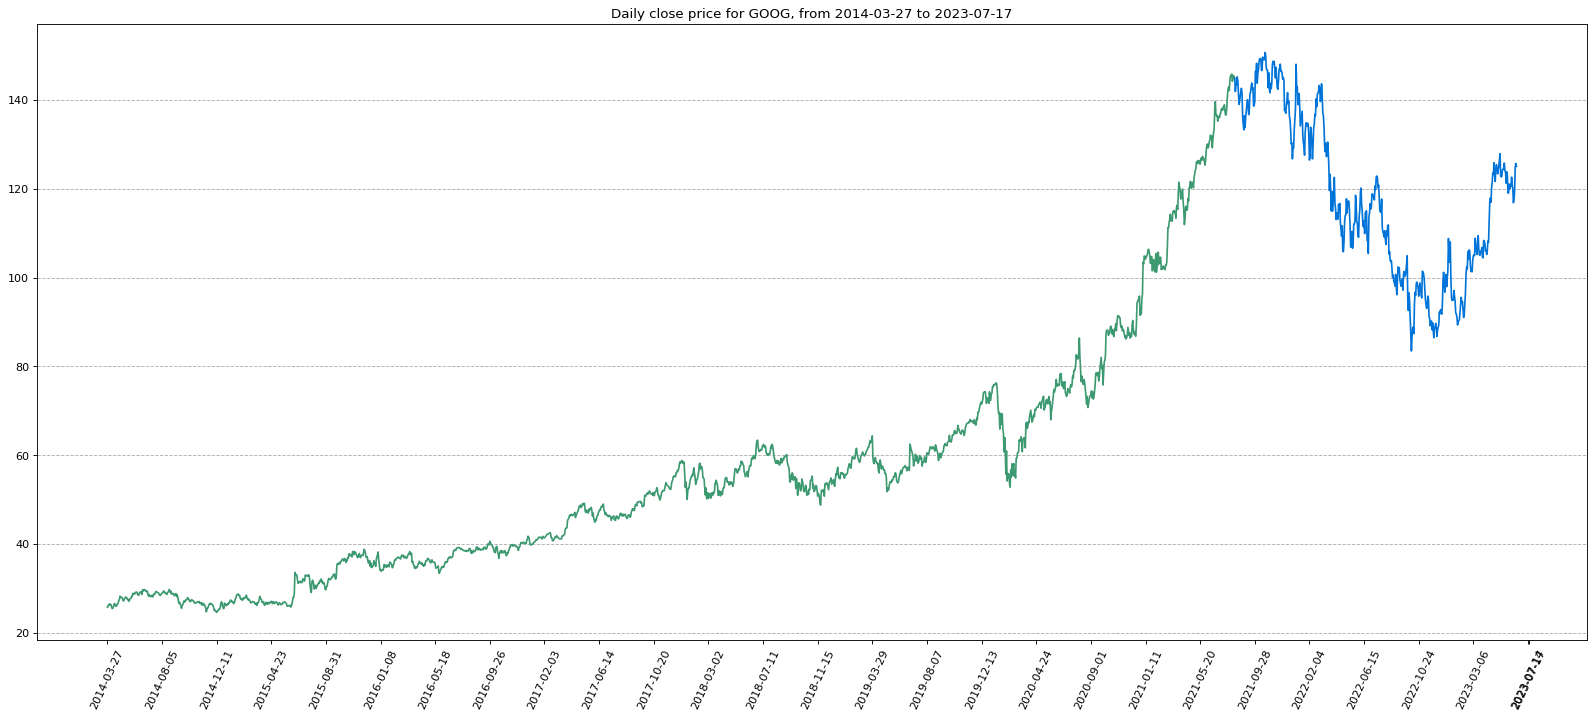

In [8]:
#Plot Train and Validation Data inb different colors
fig, ax = plt.subplots(figsize=(25, 10), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

DatesToPlot=Dates[config["data"]["window_size"]:]



data_y_train_to_plot = scaler.inverse_transform(data_y_train)
data_y_val_to_plot = scaler.inverse_transform(data_y_val)


plt.plot(DatesToPlot[:split_index], data_y_train_to_plot, color=config["plots"]["color_train"])
plt.plot(DatesToPlot[split_index:], data_y_val_to_plot, color=config["plots"]["color_val"])

xticks = [Dates[i] if ((i%config["plots"]["xticks_interval"]==0) or i==NumberDatapoints-1) else None for i in range(len(Dates))] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks , rotation=65)

ticks2 = ax.xaxis.get_major_ticks()
counter=0
for i in xticks:
    if i is not None:
        ticks2[counter].set_visible(True)
        counter+=1
    else:
        ticks2[counter].set_visible(False)
        counter+=1

plt.title("Daily close price for " + Company + ", " + Date_Range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')

In [9]:
#Init Dataset and Dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

print(data_x_train.shape)

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, axis=2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

(1857, 20)
Train data shape (1857, 20, 1) (1857,)
Validation data shape (465, 20, 1) (465,)


In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

In [11]:
#Define LSTM currently input which is Stock Price

import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [12]:
#Train LSTM
import torch.optim as optim


def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]
    return epoch_loss, lr

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

history=[]

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    history.append({"train_loss": loss_train,
                    "valid_loss": loss_val,
                       })
    
    print('Epoch[{}/{}] | loss train:{:.6f}, loss test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.093167, loss test:0.008012 | lr:0.010000
Epoch[2/100] | loss train:0.015783, loss test:0.006951 | lr:0.010000
Epoch[3/100] | loss train:0.016395, loss test:0.009369 | lr:0.010000
Epoch[4/100] | loss train:0.018652, loss test:0.004324 | lr:0.010000
Epoch[5/100] | loss train:0.014550, loss test:0.036629 | lr:0.010000
Epoch[6/100] | loss train:0.012149, loss test:0.014855 | lr:0.010000
Epoch[7/100] | loss train:0.015339, loss test:0.008390 | lr:0.010000
Epoch[8/100] | loss train:0.012035, loss test:0.004755 | lr:0.010000
Epoch[9/100] | loss train:0.015616, loss test:0.011697 | lr:0.010000
Epoch[10/100] | loss train:0.014355, loss test:0.005184 | lr:0.010000
Epoch[11/100] | loss train:0.010620, loss test:0.004936 | lr:0.010000
Epoch[12/100] | loss train:0.011596, loss test:0.003731 | lr:0.010000
Epoch[13/100] | loss train:0.010491, loss test:0.051499 | lr:0.010000
Epoch[14/100] | loss train:0.012370, loss test:0.015150 | lr:0.010000
Epoch[15/100] | loss train:0.

In [13]:
train_loss = []
valid_loss = []

for x in history:
    train_loss.append(x["train_loss"])
    valid_loss.append(x["valid_loss"])
    
epochs = np.arange(int(config["training"]["num_epoch"]))

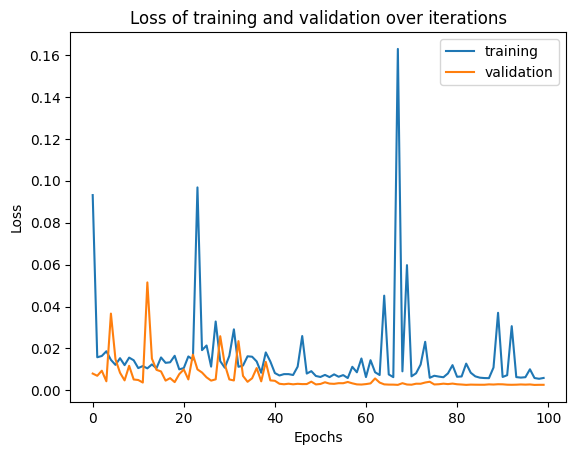

In [14]:
plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of training and validation over iterations")
plt.legend(["training", "validation"])
plt.show()

In [15]:
# here we re-initialize dataloader so the data doesn't shuffle, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

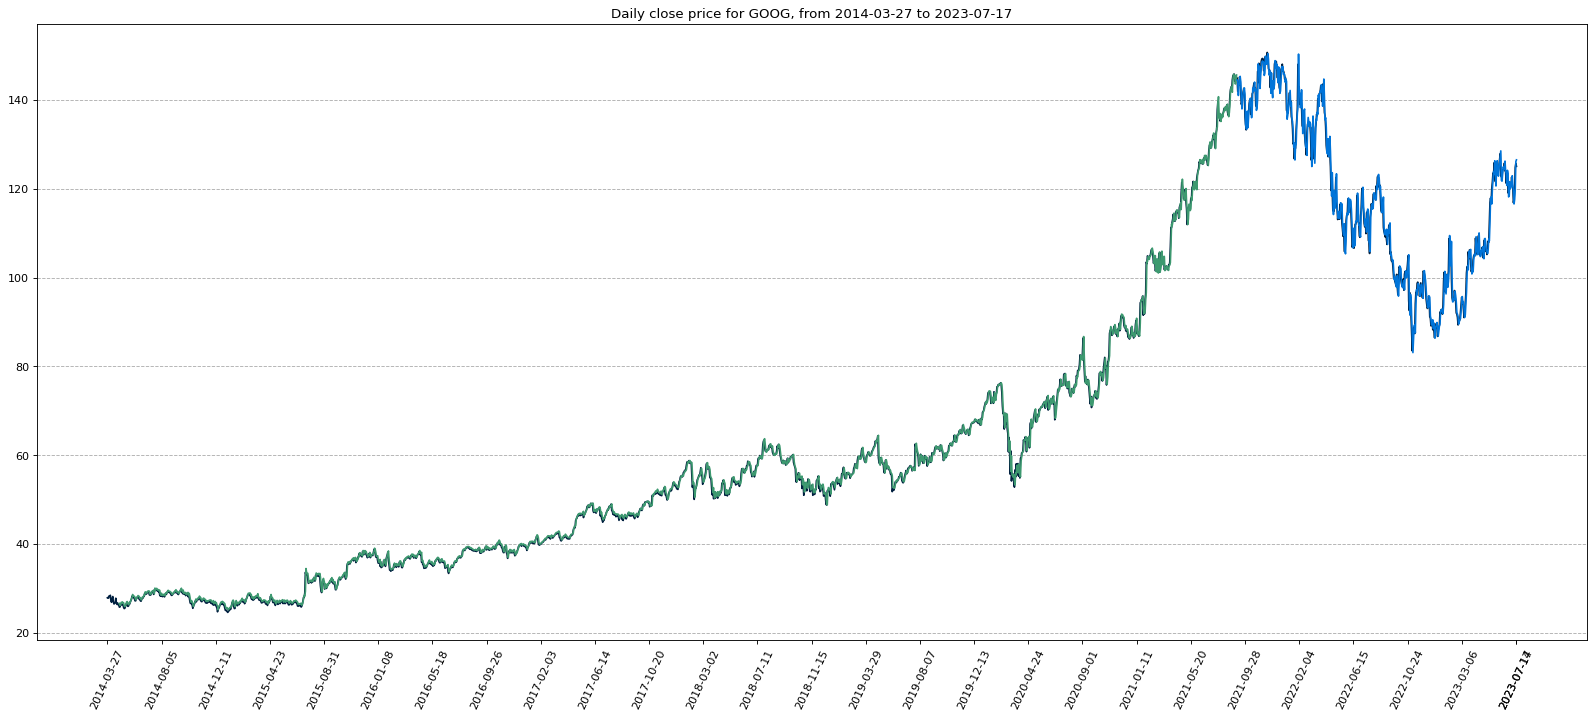

In [16]:
#Plot forecasted Prices and real Prices
fig, ax = plt.subplots(figsize=(25, 10), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))

DatesToPlot=Dates[config["data"]["window_size"]:]



data_y_train_to_pred = scaler.inverse_transform(predicted_train)
data_y_val_to_pred = scaler.inverse_transform(predicted_val)


plt.plot(Dates, Prices, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(DatesToPlot[:split_index], data_y_train_to_pred,label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(DatesToPlot[split_index:], data_y_val_to_pred, label="Predicted prices (val)",color=config["plots"]["color_val"])

xticks = [Dates[i] if ((i%config["plots"]["xticks_interval"]==0) or i==NumberDatapoints-1) else None for i in range(len(Dates))] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks , rotation=65)

ticks2 = ax.xaxis.get_major_ticks()
counter=0
for i in xticks:
    if i is not None:
        ticks2[counter].set_visible(True)
        counter+=1
    else:
        ticks2[counter].set_visible(False)
        counter+=1

plt.title("Daily close price for " + Company + ", " + Date_Range)
plt.grid(visible=None, which='major', axis='y', linestyle='--')

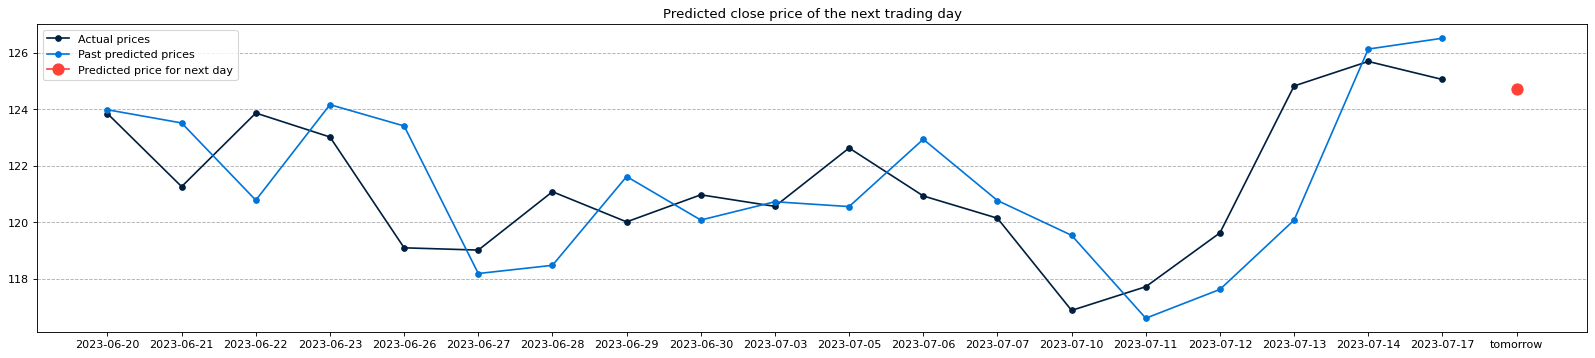

Predicted close price of the next trading day: 124.71


In [17]:
# predict the closing price of the next trading day
import torch as torch

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()


# prepare plots
plot_range = 20
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val[-plot_range+1:])
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val[-plot_range+1:])


prediction = scaler.inverse_transform(prediction)
to_plot_data_y_test_pred[-1] = prediction.item()


to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)


# plot
Dates = list(Dates)
plot_date_test = Dates[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))